# **Convolutional Neural Network (CNN)**


## Objective

1. Implement **Convolutional Neural Network(CNN)** using pytorch
2. Comparision between **Multi-Layer Perceptron (MLP)** and **CNN**



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import time 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

##**1.Convolutional Neural Network(CNN)**


- Convolutional layer can be defined by `torch.nn.Conv2d` 
- Convolutional layer needs different arguments from fully connected layer(nn.Linear)
  - FC layer needs **size of input feature** and **size of output feature** for arguments
  - Convolutional layer needs **a number of input channel** and **a number of output channel** similarly, but also it needs **size of kernel (filter)** 
- Convolutional layer utilizes different weight from FC layer
  - FC layer utilizes weight size of 2-dimentional matrix (*output feature size, input feature size*)
  - Convolutional layer utilizes weight size of  4-dimentional tensor (*output channel size, input channel size, kernel height, kernel width*)


In [ ]:
linear_layer = nn.Linear(in_features=784, out_features=400)
convolutional_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5))
print("Shape of Linear layer weight:" ,end=" ")
print(linear_layer.weight.shape)
print("Shape of Convolutional layer weight:", end=" ")
print(convolutional_layer.weight.shape)

Shape of Linear layer weight: torch.Size([400, 784])
Shape of Convolutional layer weight: torch.Size([32, 3, 5, 5])


Loading MNIST dataset using a package `torchvision`

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


These are functions for visualizing features of CNN. You don't have to look in detail.

In [ ]:
def vis_feat(f1, f2, inp):
  l = [f1, f2]
  fig, axes = plt.subplots(11, 8, figsize=(12.5,12.5))  
  plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace=0, hspace=0.1)
  ax = axes[0,0]
  ax.imshow(inp[0], cmap='gray_r')
  ax.set_title('Original image')    
  ax.axis('off') 
  
  for i in range(7):
    ax = axes[0,i+1]
    ax.axis('off')  

  for i in range(32):
      r = 2 + i // 8
      c = i % 8
      ax = axes[r, c]             
      ax.imshow(f1[i], cmap='gray_r')
      if i == 0:
        ax.set_title('Output from conv1')      
      ax.axis('off')
      if i < 8:
        ax = axes[1, i]
        ax.axis('off')

  for i in range(32):
    r = 7 + i // 8
    c = i % 8
    ax = axes[r, c]             
    ax.imshow(f2[i], cmap='gray_r')
    if i == 0:
      ax.set_title('Output from conv2')      
    ax.axis('off')
    if i < 8:
        ax = axes[6, i]
        ax.axis('off')

  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
def vis(model, loader):
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      images, labels = data
      f1 = model.conv1(images)
      f2 = model.conv2(model.pool(F.relu(f1)))

      vis_feat(f1[0], f2[0], images[0])
      break   

### **1.1. Implement of CNN using pytorch**


Construct convolutional neural network below using `torch.nn.Conv2d`, `torch.nn.MaxPool2d`, and `torch.nn.Linear` 
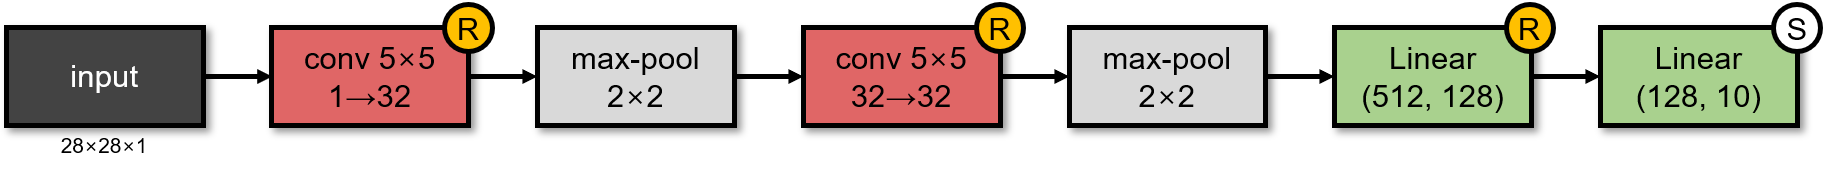

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Construct convolutional layer    
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5))
    # num of input channel = 1, num of output channel 32, kernel size = 5×5 
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max-pooling with kernel size = 2×2, stride = 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    # num of input channel = 1, num of output channel 32, kernel size = 5×5 (5 = 5×5)    
    
    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    batchsize = x.size(0)
    x = self.conv1(x) # output for feature visuallization
    x = self.pool(F.relu(x)) # Convolutional layer -> ReLU activation -> max_pooling
    x = self.conv2(x)
    x = self.pool(F.relu(x))
    x = x.view(batchsize,-1) # Change the shape of output from [batch_size, channels, height, width] to [batch_size, channels*height*width]
    x = F.relu(self.fc1(x))
    out = self.fc2(x)
    return out

Define a function `train` for train the model and `evaluate` for test the model and measure its accuracy  

In [ ]:
def train(model, n_epoch, loader, optimizer, criterion, device="cpu"):
  model.train()
  for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(input=outputs, target=labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss/len(loader)))
  print('Training Finished')


In [ ]:
def evaluate(model, loader, device="cpu"):
  model.eval()
  total=0
  correct=0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
    
  acc = 100*correct/total
  return acc

Train the model using a function `train`

When we use only CPU, it takes long time due to tremendous computation of convolutional layer.

You can see how much it takes for one epoch for example.

In [ ]:
cnn_model = CNN()
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion)

100%|██████████| 1/1 [00:41<00:00, 41.01s/it]

Epoch 0, loss = 2.176
Training Finished


As you can see, it takes really long for just one epoch.

Rather than using CPU, let's try other way. 

Train and test the model using functions `train` and `evaluate`  

You can reduce training time using GPU that works as neural network accelarator.

- CNN shares parameters of the kernal, so you can accelarate the network with powerful parallel computing of GPU. 

In [ ]:
cnn_model = CNN().to("cuda")
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))


  7%|▋         | 1/15 [00:05<01:21,  5.79s/it]

Epoch 0, loss = 2.210


 13%|█▎        | 2/15 [00:11<01:14,  5.77s/it]

Epoch 1, loss = 0.909


 20%|██        | 3/15 [00:17<01:08,  5.74s/it]

Epoch 2, loss = 0.389


 27%|██▋       | 4/15 [00:22<01:03,  5.73s/it]

Epoch 3, loss = 0.300


 33%|███▎      | 5/15 [00:28<00:57,  5.72s/it]

Epoch 4, loss = 0.248


 40%|████      | 6/15 [00:34<00:51,  5.72s/it]

Epoch 5, loss = 0.211


 47%|████▋     | 7/15 [00:40<00:45,  5.71s/it]

Epoch 6, loss = 0.183


 53%|█████▎    | 8/15 [00:45<00:40,  5.72s/it]

Epoch 7, loss = 0.162


 60%|██████    | 9/15 [00:51<00:34,  5.71s/it]

Epoch 8, loss = 0.147


 67%|██████▋   | 10/15 [00:57<00:28,  5.71s/it]

Epoch 9, loss = 0.133


 73%|███████▎  | 11/15 [01:02<00:22,  5.73s/it]

Epoch 10, loss = 0.122


 80%|████████  | 12/15 [01:08<00:17,  5.72s/it]

Epoch 11, loss = 0.114


 87%|████████▋ | 13/15 [01:14<00:11,  5.73s/it]

Epoch 12, loss = 0.107


 93%|█████████▎| 14/15 [01:20<00:05,  5.73s/it]

Epoch 13, loss = 0.100


100%|██████████| 15/15 [01:25<00:00,  5.72s/it]

Epoch 14, loss = 0.094
Training Finished


Test accuracy: 97.63%


Now, let's see the visualization of features of CNN we trained.

You can run it several times to see different images each time.

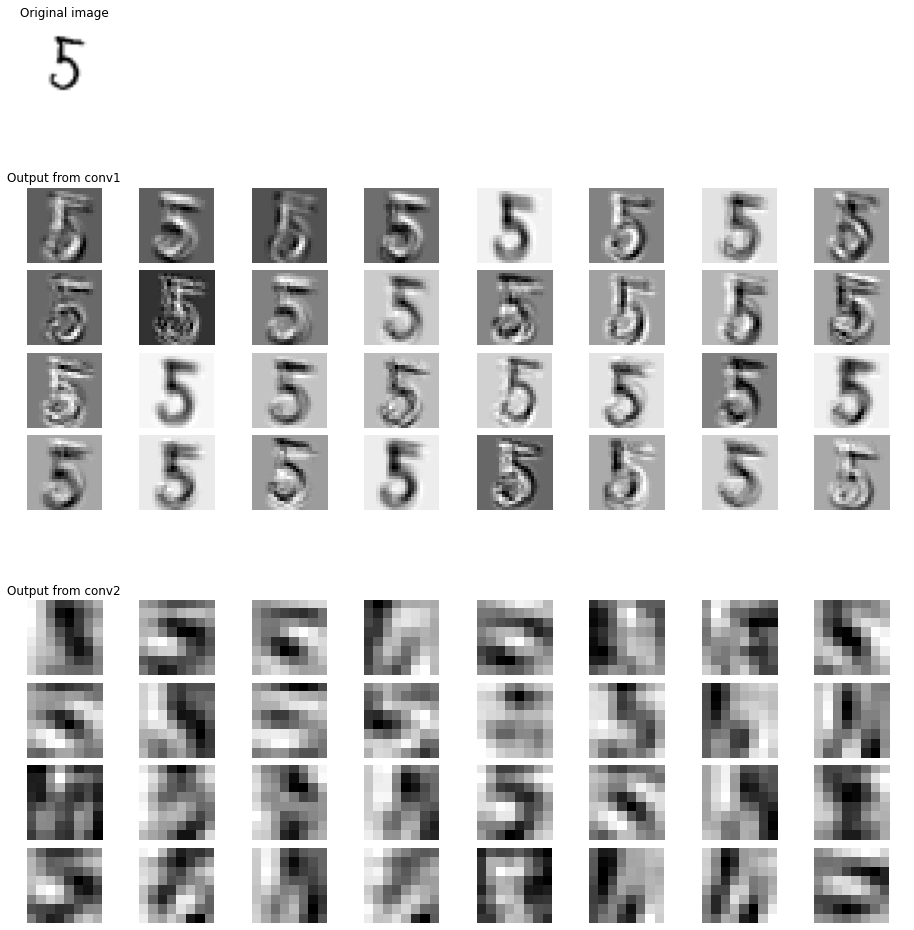

In [ ]:
vis(cnn_model.cpu(), trainloader)

### **1.2.Comparison between CNN and Multi-Layer Perceptron (MLP)**

Compare CNN with MLP
  - CNN needs more number of computations and also longer training time
  - CNN has fewer parameters
  - CNN shows higher performance in image processing task  

Construct MLP using `torch.nn.Linear`

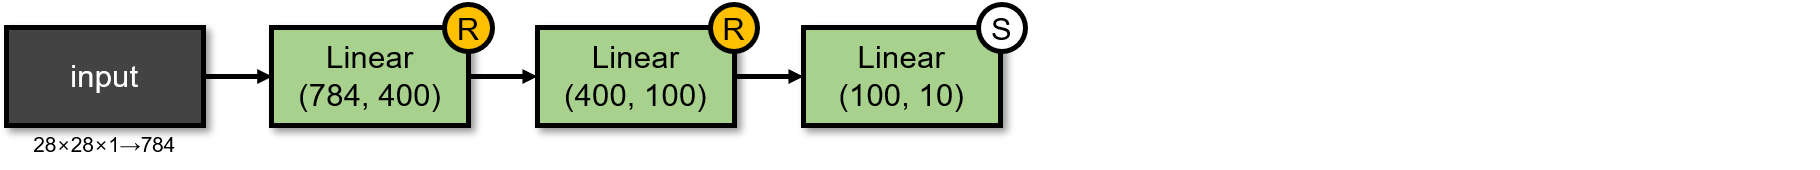

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=400)
    self.layer2 = nn.Linear(in_features=400, out_features=100)
    self.layer3 = nn.Linear(in_features=100, out_features=10)

  def forward(self, x):
    batchsize = x.size(0)
    x = x.view(batchsize, -1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    out = self.layer3(x)
    return out

Train and Test the model using functions `train` and `evaluate`

  - Check training time and performance(accuracry) and compare with CNN

In [ ]:
mlp_model = MLP().to("cuda")
optimizer = optim.SGD(params=mlp_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=mlp_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(mlp_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:04<01:05,  4.67s/it]

Epoch 0, loss = 2.241


 13%|█▎        | 2/15 [00:09<01:00,  4.66s/it]

Epoch 1, loss = 1.845


 20%|██        | 3/15 [00:14<00:56,  4.67s/it]

Epoch 2, loss = 1.105


 27%|██▋       | 4/15 [00:18<00:51,  4.69s/it]

Epoch 3, loss = 0.719


 33%|███▎      | 5/15 [00:23<00:47,  4.71s/it]

Epoch 4, loss = 0.558


 40%|████      | 6/15 [00:28<00:42,  4.71s/it]

Epoch 5, loss = 0.474


 47%|████▋     | 7/15 [00:32<00:37,  4.71s/it]

Epoch 6, loss = 0.426


 53%|█████▎    | 8/15 [00:37<00:32,  4.70s/it]

Epoch 7, loss = 0.395


 60%|██████    | 9/15 [00:42<00:28,  4.69s/it]

Epoch 8, loss = 0.372


 67%|██████▋   | 10/15 [00:46<00:23,  4.69s/it]

Epoch 9, loss = 0.355


 73%|███████▎  | 11/15 [00:51<00:18,  4.69s/it]

Epoch 10, loss = 0.341


 80%|████████  | 12/15 [00:56<00:14,  4.70s/it]

Epoch 11, loss = 0.330


 87%|████████▋ | 13/15 [01:01<00:09,  4.69s/it]

Epoch 12, loss = 0.319


 93%|█████████▎| 14/15 [01:05<00:04,  4.68s/it]

Epoch 13, loss = 0.310


100%|██████████| 15/15 [01:10<00:00,  4.69s/it]

Epoch 14, loss = 0.302
Training Finished


Test accuracy: 91.60%


Compare the number of parameters between CNN and MLP
  - Check which model has more parameters  

In [ ]:
mlp_num_parameters = sum(param.numel() for param in mlp_model.parameters() if param.requires_grad)
mlp_acc = evaluate(mlp_model, testloader, device="cuda")
print('Total Number of trainable parameters of MLP: {}, Accuracy of MLP: {:.2f}%'.format(mlp_num_parameters, mlp_acc))

cnn_model = cnn_model.to("cuda")
cnn_num_parameters = sum(param.numel() for param in cnn_model.parameters() if param.requires_grad)
cnn_acc = evaluate(cnn_model, testloader, device="cuda")
print('Total Number of trainable parameters of CNN: {}, Accuracy of CNN: {:.2f}%'.format(cnn_num_parameters, cnn_acc))

Total Number of trainable parameters of MLP: 355110, Accuracy of MLP: 91.60%
Total Number of trainable parameters of CNN: 93418, Accuracy of CNN: 97.63%


###**Task 1.Construct CNN by yourself**


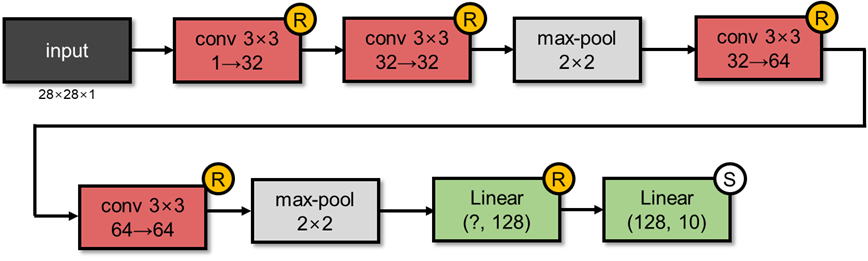

In [ ]:
class CNN2(nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    # Construct convolutional layer    
    ############# ENTER YOUR CODE HERE #################
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3))
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))
    self.fc1 = nn.Linear(in_features=1024, out_features=128)
    #####################################################
       
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    ############## ENTER YOUR CODE HERE ##############
    batchsize = x.size(0)
    x = self.conv1(x) 
    x = self.conv2(x) 
    x = self.pool(F.relu(x))
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.pool(F.relu(x))  
    x = x.view(batchsize,-1) 
    x = F.relu(self.fc1(x))
    ################################################

    out = self.fc2(x)    
    return out

Now, Let's see you've done well.

In [ ]:
cnn_model2 = CNN2().to("cuda")
optimizer = optim.SGD(params=cnn_model2.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model2, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model2, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:07<01:39,  7.11s/it]

Epoch 0, loss = 2.286


 13%|█▎        | 2/15 [00:14<01:32,  7.10s/it]

Epoch 1, loss = 1.080


 20%|██        | 3/15 [00:21<01:25,  7.09s/it]

Epoch 2, loss = 0.330


 27%|██▋       | 4/15 [00:28<01:17,  7.08s/it]

Epoch 3, loss = 0.225


 33%|███▎      | 5/15 [00:35<01:10,  7.07s/it]

Epoch 4, loss = 0.168


 40%|████      | 6/15 [00:42<01:03,  7.06s/it]

Epoch 5, loss = 0.133


 47%|████▋     | 7/15 [00:49<00:56,  7.05s/it]

Epoch 6, loss = 0.112


 53%|█████▎    | 8/15 [00:56<00:49,  7.06s/it]

Epoch 7, loss = 0.099


 60%|██████    | 9/15 [01:03<00:42,  7.06s/it]

Epoch 8, loss = 0.087


 67%|██████▋   | 10/15 [01:10<00:35,  7.05s/it]

Epoch 9, loss = 0.080


 73%|███████▎  | 11/15 [01:17<00:28,  7.05s/it]

Epoch 10, loss = 0.074


 80%|████████  | 12/15 [01:24<00:21,  7.05s/it]

Epoch 11, loss = 0.069


 87%|████████▋ | 13/15 [01:31<00:14,  7.05s/it]

Epoch 12, loss = 0.064


 93%|█████████▎| 14/15 [01:38<00:07,  7.05s/it]

Epoch 13, loss = 0.061


100%|██████████| 15/15 [01:45<00:00,  7.06s/it]

Epoch 14, loss = 0.055
Training Finished


Test accuracy: 98.21%


##**(Optional) Improving CNN using batch-normalization**

- CNN can be stabilized by batch normailization just like MLP
- You should use `torch.nn.Batchnorm2d` for CNN because the output of CNN is 2D×(num of channel)

In [ ]:
class CNN_BN(nn.Module):
  def __init__(self):
    super(CNN_BN, self).__init__()
    # Construct convolutional layer
    ##################################################
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5))    
    self.bn1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max-pooling with kernel size = 2×2, stride = 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)    
    self.bn2 = nn.BatchNorm2d(32)       
    #####################################################

    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.bn3 = nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    batchsize = x.size(0)
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Convolutional layer -> BN -> ReLU activation -> max_pooling
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(batchsize,-1) # Change the shape of output from [batch_size, channels, height, width] to [batch_size, channels*height*width]
    x = F.relu(self.bn3(self.fc1(x)))
    out = self.fc2(x)
    return out

In [ ]:
cnn_bn_model = CNN_BN().to("cuda")
optimizer = optim.SGD(params=cnn_bn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_bn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_bn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))